In [1]:
import numpy as np
import rasterio as rio
import rasterio.mask
from rasterio.merge import merge

import matplotlib.pyplot as plt

from osgeo import gdal

import skimage as ski
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu

## Input: filepath to your multispectral image (.tif)

In [2]:
file_path = r"Z:\UAV_Share\Agisoft Metashape Projects\crittenden_2023\chardonnay_20230823\chardonnay_20230823.tif" # Replace with your image filepath

## Perform a series of thresholding operations on the image to generate a crop mask

Optional: Un-comment the plt.imshow() lines to see intermediate masks

In [10]:
# Convert multispec tiff to RGN, 8bit

raw = gdal.Open(file_path)
width = raw.RasterXSize
height = raw.RasterYSize
imgarr=raw.ReadAsArray()

# Read the bands as an array
bands = []
for i in range(1, 11):  # Assuming bands are numbered from 1 to 10
    band = raw.GetRasterBand(i).ReadAsArray(0, 0, width, height)
    bands.append(band)

# Select three bands for Red-Green-NIR representation (adjust the indices as needed)
red_band = bands[5]
green_band = bands[3]
nir_band = bands[9]

# Normalize the pixel values to the range [0, 255]
red_band = ((red_band - np.min(red_band)) / (np.max(red_band) - np.min(red_band))) * 255
green_band = ((green_band - np.min(green_band)) / (np.max(green_band) - np.min(green_band))) * 255
nir_band = ((nir_band - np.min(nir_band)) / (np.max(nir_band) - np.min(nir_band))) * 255

# Create an RGB image by stacking the bands and converting to uint8
rgn_image = np.dstack((red_band, green_band, nir_band)).astype(np.uint8)

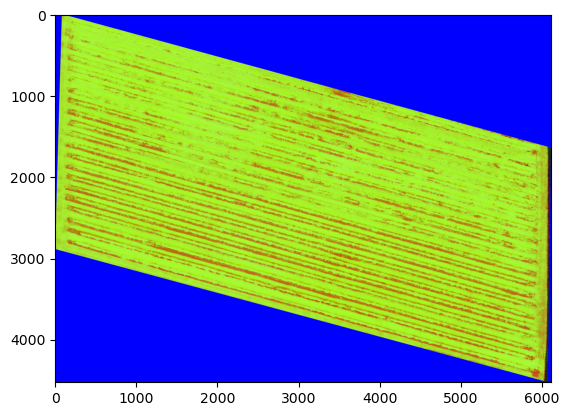

In [13]:
# Convert the Red-Green-NIR image to the Hue-Saturation-Value (HSV) color space
hsv_img = rgb2hsv(rgn_image)
#plt.imshow(hsv_img)

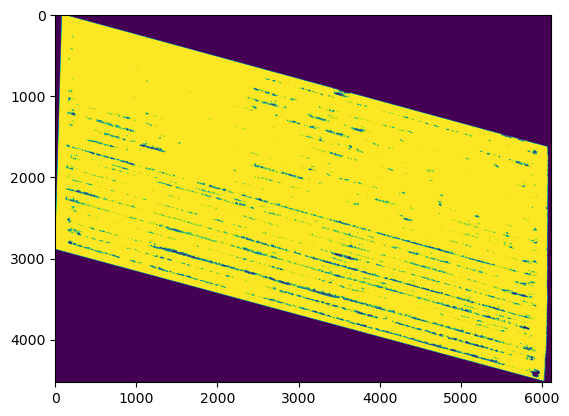

In [14]:
# Otsu's threshold on the S (saturation) channel
# This masks the shadowed pixels

s_img = hsv_img[:,:,1]
s_thresh = threshold_otsu(s_img)
s_binary = s_img > s_thresh

#plt.imshow(s_binary)

In [15]:
# Convert to a numeric binary mask and reshape
s_numeric = s_binary*1
s_numeric_rs = s_numeric.reshape(s_numeric.shape[0],s_numeric.shape[1],1)

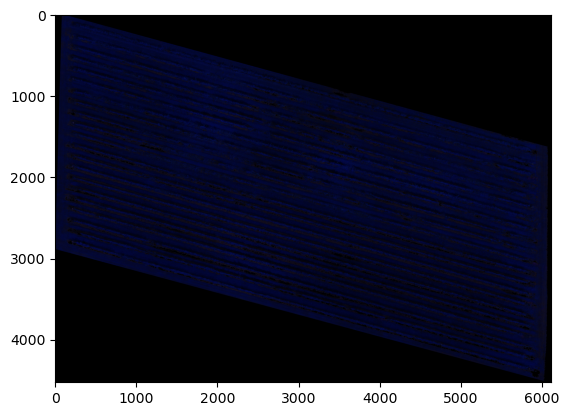

In [20]:
# Apply shadow mask to the original RGN image 
rgn_shadow_masked = rgn_image*s_numeric_rs
#plt.imshow(rgn_shadow_masked)

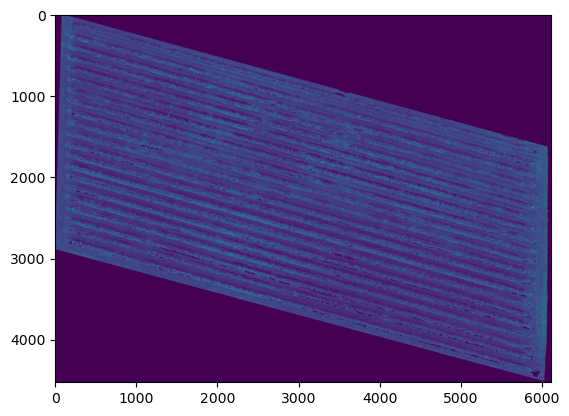

In [22]:
# Get single-banded images for the green and NIR channels

g_img = rgn_shadow_masked[:, :, 1]
nir_img = rgn_shadow_masked[:, :, 2]
#plt.imshow(g_img)
#plt.imshow(nir_img)

In [23]:
# Otsu's threshold on the G channel of shadow masked image
g_thresh = threshold_otsu(g_img)
g_binary = g_img > g_thresh

# convert to numeric and reshape
g_numeric = g_binary*1
g_numeric_rs = g_numeric.reshape(g_numeric.shape[0],g_numeric.shape[1],1)

In [24]:
# Otsu's threshold on the NIR channel of shadow masked image
nir_thresh = threshold_otsu(nir_img)
nir_binary = nir_img > nir_thresh

# convert to numeric and reshape
nir_numeric = nir_binary*1
nir_numeric_rs = nir_numeric.reshape(nir_numeric.shape[0],nir_numeric.shape[1],1)

In [34]:
# Combine G and NIR masks
nir_g = nir_numeric_rs + g_numeric_rs

# replace all values less than 2 with 0

nir_g[nir_g < 2] = 0

# replace all 2s with 1s

nir_g[nir_g > 0] = 1

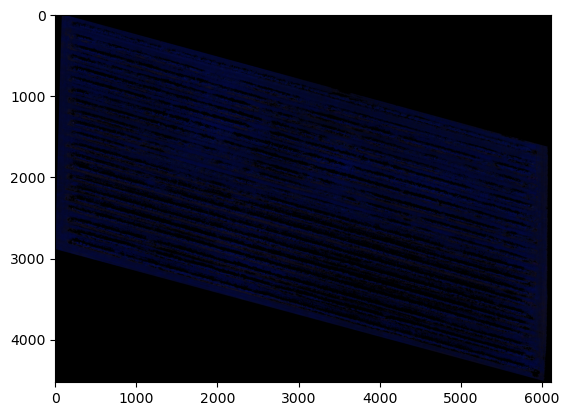

In [35]:
# multiply NIR+G mask by the shadow-masked image

noshadow_justvine = nir_g * rgn_shadow_masked

#plt.imshow(noshadow_justvine)

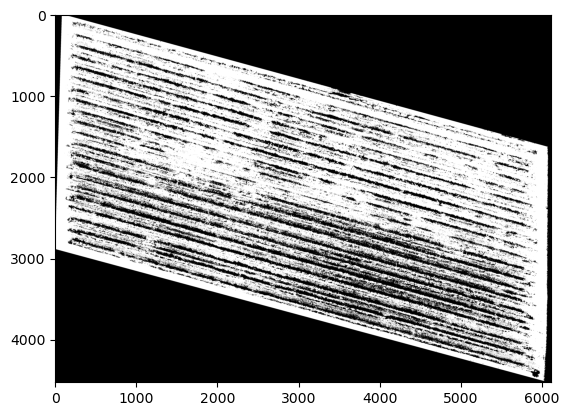

In [36]:
#plt.imshow(nir_g, cmap=plt.cm.gray)

In [37]:
def write_geotiff(filename, arr, in_fp):
    in_ds = gdal.Open(in_fp)
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    #if out_ds is not None:
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

In [38]:
# Reshape final mask to 2 dimensions
nir_g_2d = nir_g.reshape(nir_g.shape[0], nir_g.shape[1])

## Export the crop mask .tif file

In [39]:
#write_geotiff('vinemask.tif', nir_g_2d, file_path)

## Export the crop mask.npy file

In [ ]:
np.save('vinemask.npy', nir_g_2d) #modify output filename as you like